In [1]:
import numpy as np
import sys

import itertools

In [2]:
sys.path.append("../utils/")

In [3]:
import plot_utils as pu

In [4]:
X = np.load("../../data/simulation/1000_35_like_true/amp_gr.npy")
Y = np.load("../../data/simulation/1000_35_like_true/populations_gr.npy")

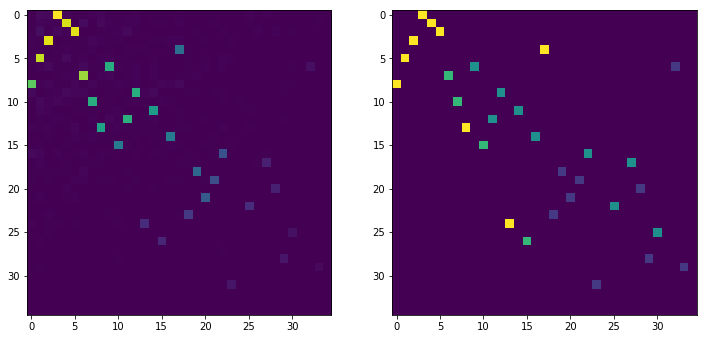

In [5]:
pu.plot_grs(X[0], Y[0], s = 12)

In [6]:
gr, gr_y = X[0], Y[0]

In [7]:
def gr_to_pairs(gr):
    N = gr.shape[0]
    pairs = [x for x in itertools.product(range(N), range(N))]
    pairs_counts = {}
    
    for p in pairs:
        if gr[p[0], p[1]] > 0: pairs_counts[p] = gr[p[0], p[1]].astype(int)
    
    
    p_to_n = dict(zip(pairs_counts.keys(), np.arange(len(pairs)).astype(int)))
    n_to_p = dict(zip(np.arange(len(pairs)).astype(int), pairs_counts.keys()))
    
    return pairs_counts, p_to_n, n_to_p, N

In [8]:
def pairs_to_sparse_gr(p_to_n):
    N = len(p_to_n)
    first = dict(zip(range(N), [[] for i in range(N)] ))
    second = dict(zip(range(N), [[] for i in range(N)]))
    
    for p in p_to_n.keys():
        first[p[0]].append(p)
        second[p[1]].append(p)
    
    gr = np.zeros((N, N))
    
    for p in p_to_n.keys():
        for p2 in first[p[1]]:
            gr[p_to_n[p]][p_to_n[p2]] = 1
    
    return gr, first, second

In [9]:
pairs, p_to_n, n_to_p, N = gr_to_pairs(gr)

In [10]:
d = {(0,1) : 0, (1,0) : 1, (1,2) : 2}

In [11]:
gr_n = pairs_to_sparse_gr(p_to_n)

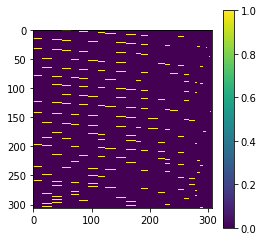

In [12]:
pu.plot_gr(gr_n[0], s  =4)

In [13]:
def make_vertexes_embs(gr, p_to_n):
    embs = np.zeros((len(p_to_n), 5))
    
    for i, p in enumerate(p_to_n.keys()):
        embs[i, 0] = gr[p[0], p[1]]
        embs[i, 1] = embs[i, 0] / gr[p[0]].sum()
        embs[i, 2] = embs[i, 0] / gr[:, p[1]].sum()
        
        embs[i, 3] = embs[i, 0] / max(1, gr[:, p[0]].sum())
        embs[i, 4] = embs[i, 0] / max(1, gr[p[1]].sum())
    return embs
        

In [14]:
def make_y(gr_y, p_to_n):
    y = np.zeros(len(p_to_n)).astype(int)
    
    for i, p in enumerate(p_to_n.keys()):
        y[i] = (gr_y[p[0], p[1]] > 0).astype(int)
        
    return y

In [15]:
from tqdm import tqdm_notebook

In [17]:
X.shape

(1000, 35, 35)

In [19]:
NEW_X = []
NEW_Y = []
adj = []


for x, y in tqdm_notebook(zip(X, Y)):
    pairs, p_to_n, n_to_p, N = gr_to_pairs(x)
    gr = pairs_to_sparse_gr(p_to_n)
    
    
    new_x = make_vertexes_embs(x, p_to_n)
    new_y = make_y(y, p_to_n) 
    
    adj.append(gr)
    NEW_X.append(new_x)
    NEW_Y.append(new_y)

A Jupyter Widget

In [31]:
embs = np.array(NEW_X)
adjs = np.array(adj)
target = np.array(NEW_Y)

In [34]:
np.save("../../data/gnn_prepared/embs", embs)
np.save("../../data/gnn_prepared/adjs", adjs)
np.save("../../data/gnn_prepared/target", target)

In [168]:
train_x = np.vstack(NEW_X[:800])[:, 1:]
train_y = np.hstack(NEW_Y[:800])

val_x = np.vstack(NEW_X[800:])[:, 1:]
val_y = np.hstack(NEW_Y[800:])

In [169]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [170]:
#lr = LogisticRegression()
lr = SVC()

In [171]:
lr.fit(train_x, train_y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [172]:
(lr.predict(val_x) == val_y).sum() / len(val_y)

0.9989836778665365

In [36]:
graph = np.load("../../data/graphs/ES3_22.npy")

In [37]:
cut= 35
pairs, p_to_n, n_to_p, N = gr_to_pairs(graph[:cut, :cut])

In [38]:
gr_x = make_vertexes_embs(graph, p_to_n)

In [42]:
np.save("../../data/gnn_prepared/ES3_22_embs", gr_x)

In [43]:
import pickle

In [45]:
pickle.dump(n_to_p, open("../../data/gnn_prepared/ES3_22_n_to_p", 'wb'))

In [48]:
np.save("../../data/gnn_prepared/ES3_22_adj", pairs_to_sparse_gr(p_to_n)[0])

In [47]:
pairs_to_sparse_gr(p_to_n)[0]

array([[1., 1., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [49]:
answ = np.load("../../data/gnn_prepared/answ_ES3.npy")

In [162]:
import matplotlib.pyplot as plt

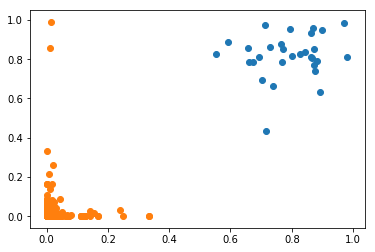

In [176]:
plt.scatter(gr_x[lr.predict(gr_x[:,1:3]) == 1,1], gr_x[lr.predict(gr_x[:,1:3]) == 1, 2])
plt.scatter(gr_x[lr.predict(gr_x[:,1:3]) == 0,1], gr_x[lr.predict(gr_x[:,1:3]) == 0, 2])

In [164]:
p_to_n[(1,19)]

44

In [166]:
gr_x[44]

array([1.02000000e+02, 9.77573318e-03, 8.57142857e-01, 1.72588832e-01,
       1.20000000e+00])

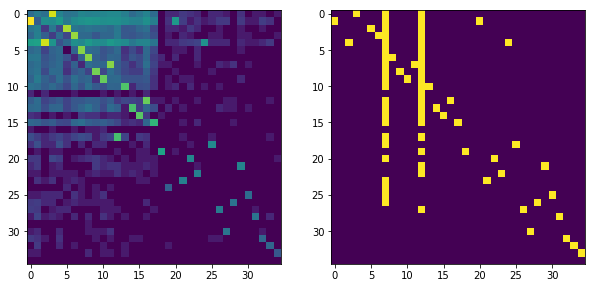

In [54]:
pu.plot_grs(graph[:cut, :cut],pairs_to_gr(np.array([x for x in p_to_n.keys()])[answ > 0.5]), log = 1, all_ticks=1)

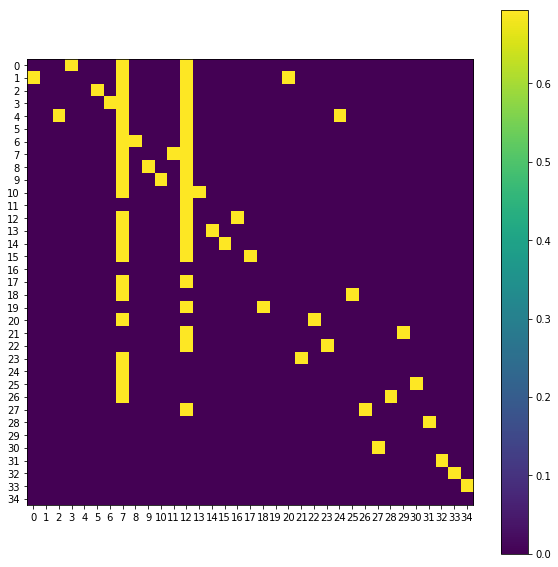

In [60]:
pu.plot_gr(pairs_to_gr(np.array([x for x in p_to_n.keys()])[answ > 0.5]), log = 1, all_ticks=1, s = 10)

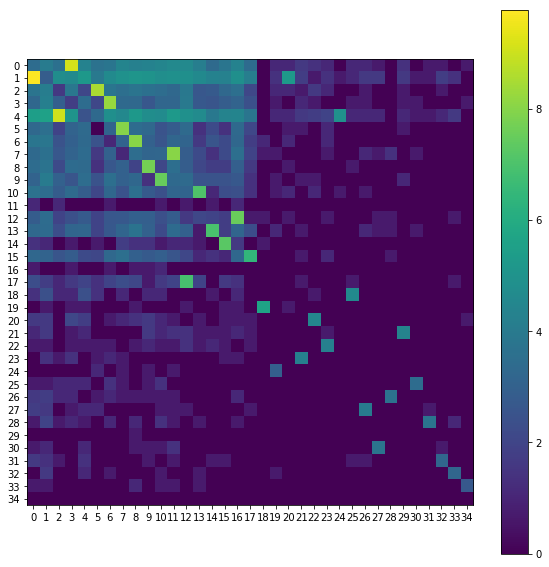

In [61]:
pu.plot_gr(graph[:cut, :cut], log = 1, all_ticks=1, s = 10)

In [55]:
def pairs_to_gr(pairs, N = None):
    if N == None:
        N = 0
        for p in pairs:
            N = max(N, max(p))
        N+=1
    
    gr = np.zeros((N, N))
    for p in pairs:
        gr[p[0],p[1]] = 1
    return gr

In [120]:
np.save("../../data/graphs/clostridium_1_3_answ.npy",pairs_to_gr(np.array([x for x in p_to_n.keys()])[lr.predict(gr_x[:,1:]) == 1]) )

In [94]:
import viz_utils as vu

In [ ]:
f = vu.plot_graphs(answ_1_gr, pos, answ_2_gr, pos, arrays_gr, shift_pos, node_size=300, figsize=(15, 20))